In [13]:
## Loading packages
library(openair);library(dplyr);library(tidyverse);library(lubridate);library(readxl);
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timetk);library(tidyquant)

In [14]:
## Data cleaning 
## Reading the excel file, starting with 12 line and giving NA as None
data <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
data <- data %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(data)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [33]:
#tiff("Temporal_variation_PM25_Anand_vihar.tiff", units="cm", width=20, height=15,res = 300)
jpeg("my_plot.jpeg", quality = 100,units="px", width=20, height=15,)
timeVariation(data,pollutant = "PM25")
dev.off()

png 
  2

    date1     date2      PM25        AT        RH        WS        SR        WD 
"POSIXct"  "POSIXt" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 


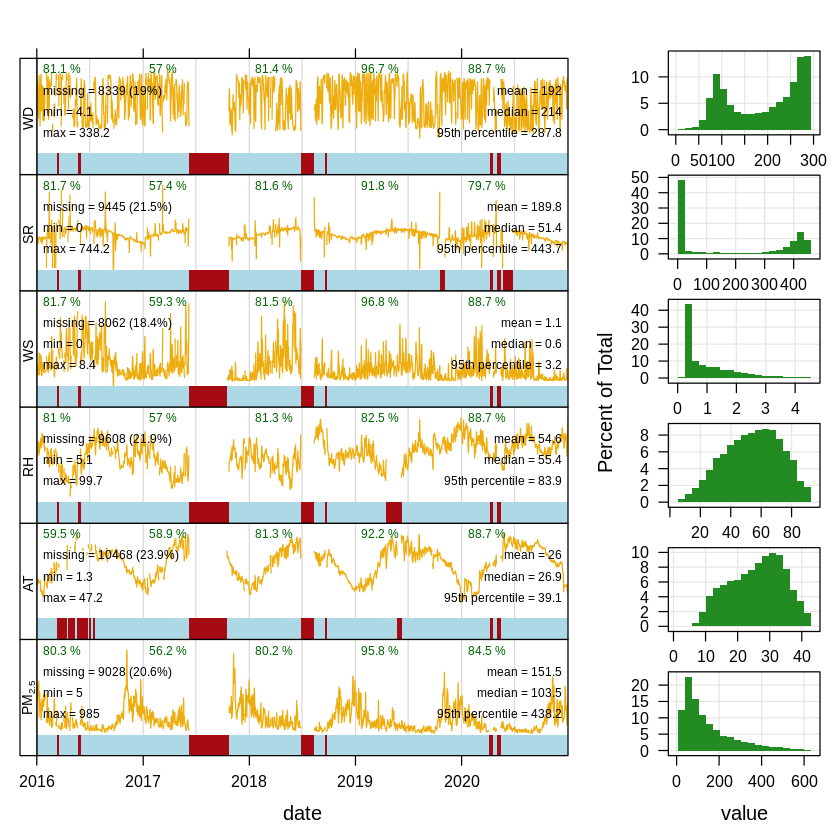

In [71]:
#jpeg("Images/Time_series_no_cleaning_PM25_Anand_vihar.jpeg", units="cm", width=20, height=15,res = 300)
data_2020 <- data %>% filter(date <= as.Date("2021-1-1"))%>% 
mutate(AT = ifelse(AT<=0,NA,AT),RH=ifelse(RH<=5,NA,RH),WS= ifelse(WS<0,NA,WS),
       PM25=ifelse(PM25<5,NA,PM25),WD=ifelse(WD<1,NA,WD))
#summaryPlot(data_2020,pollutant = "PM25",na.len = 96)
#dev.off()

In [76]:
jpeg("Images/Time_variation_PM25_Anand_vihar.jpeg", units="cm", width=20, height=15,res = 300)
timeVariation(data_2020,pollutant="PM25",ylab = "PM2.5 (ug/m3)",)
dev.off()

png 
  2

In [8]:
## Data loading and cleaning  ##
## Reading the excel file, starting with 12 line and giving NA as None value
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)


date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [4]:
## Converting the data into daily time series
daily_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    dates = as.Date(paste0(day, "-", month, "-", year), "%d-%m-%Y"),
    PM2.5 = ifelse(PM25 <=10 ,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(dates, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM25 = mean(PM25, na.rm = TRUE)) %>%
  mutate(week = week(dates))

## Putting NA if there are null values 
daily_df$PM25[is.nan(daily_df$PM25)] <- NA
head(daily_df)

`summarise()` has grouped output by 'dates', 'day', 'month'. You can override using the `.groups` argument.



dates,day,month,year,PM25,week
<date>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01,1,1,2016,359.5730,1
2016-01-02,2,1,2016,327.9150,1
2016-01-03,3,1,2016,341.3188,1
2016-01-04,4,1,2016,480.0688,1
2016-01-05,5,1,2016,433.3537,1
2016-01-06,6,1,2016,371.7995,1


In [19]:
jpeg("Images/Train_Test_Daily.jpeg", units="cm", width=20, height=15,res = 300)
daily_df %>% filter(dates < ymd("2021-01-01"))%>%
    ggplot(aes(x = dates, y = PM25)) +
    geom_rect(xmin = as.numeric(ymd("2016-01-01")),
              xmax = as.numeric(ymd("2020-01-01")),
              ymin = 0, ymax = 1000,
              fill = palette_light()[[4]], alpha = 0.01) +
    annotate("text", x = ymd("2018-01-01"), y = 800,
             color = palette_light()[[2]], label = "Train + Validation Region",fontface =2) +
    annotate("text", x = ymd("2020-06-01"), y = 800,
             color = palette_light()[[2]], label = "Test Region",fontface =2) +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) +
    labs(title = "Train and Test split", x = "",y="PM 2.5 (ug/m3)") +
    theme_tq()
dev.off()

Warning message:
“Removed 269 rows containing missing values (geom_point).”


png 
  2

In [10]:
## Converting the data into daily time series
hourly_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    PM2.5 = ifelse(PM25 <10 | PM25 >999 ,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(date,hour, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM25 = mean(PM2.5, na.rm = TRUE)) %>%
  mutate(week = week(date))

## Putting NA if there are null values 
hourly_df$PM25[is.nan(hourly_df$PM25)] <- NA
head(hourly_df)

`summarise()` has grouped output by 'date', 'hour', 'day', 'month'. You can override using the `.groups` argument.



date,hour,day,month,year,PM25,week
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01 01:00:00,1,1,1,2016,376.00,1
2016-01-01 02:00:00,2,1,1,2016,480.50,1
2016-01-01 03:00:00,3,1,1,2016,486.67,1
2016-01-01 04:00:00,4,1,1,2016,441.17,1
2016-01-01 05:00:00,5,1,1,2016,594.83,1
2016-01-01 06:00:00,6,1,1,2016,441.33,1


In [12]:
jpeg("Images/Train_Test_Hourly.jpeg", units="cm", width=20, height=15,res = 300)
hourly_df %>% filter(date < ymd("2021-01-01"))%>%
    ggplot(aes(x = date, y = PM25)) +
    geom_rect(xmin = as.numeric(as.POSIXct("2016-01-01 01:00:00")),
              xmax = as.numeric(as.POSIXct("2020-01-01 01:00:00")),
              ymin = 0, ymax = 1000,
              fill = palette_light()[[4]], alpha = 0.01) +
    annotate("text", x = as.POSIXct("2018-01-01 01:00:00"), y = 900,
             color = palette_light()[[2]], label = "Train + Validation Region",fontface =2) +
    annotate("text", x = as.POSIXct("2020-06-01 01:00:00"), y =900,
             color = palette_light()[[2]], label = "Test Region",fontface =2) +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) +
    labs(title = "Train and Test split", x = "",y="PM 2.5 (ug/m3)") +
    theme_tq()
dev.off()

Warning message:
“Removed 9208 rows containing missing values (geom_point).”


png 
  2